# LCMS Data Walkthrough

In [66]:
## Import required packages
import shutil
import numpy as np

from corems.mass_spectra.input.rawFileReader import ImportMassSpectraThermoMSFileReader
from corems.mass_spectra.output.export import LCMSExport
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulasLC
from corems.encapsulation.factory.parameters import LCMSParameters

## Read in and parse data

First we'll point an appropriate parser to a data file of the same format.  For instance, for .raw files, we'll use the `ImportMassSpectraThermoMSFileReader`.  Data from .mzml format are also supported, using the `MZMLSpectraParser`. Both parsers are available in the corems.mass_spectra.input module

In [67]:
## Point to file location
file_raw = (
    '../../tests/tests_data/lcms/Blanch_Nat_Lip_C_12_AB_M_17_NEG_25Jan18_Brandi-WCSH5801.raw'
)

## Declare/define class object that will parse the raw data
# see corems/corems/mass_spectra/input/rawFileReader.py for more information
# features from this parser can be called from instantiated object
parser = ImportMassSpectraThermoMSFileReader(file_raw)

## Instatiate LC-MS data object as LCMSBase object
# see corems/corems/mass_spectra/factory/lc_class.py for details on LCMSBase object
# pull in MS1 spectra into dataframe (without storing as MassSpectrum objects to save memory)
myLCMSobj = parser.get_lcms_obj(spectra="ms1")


### Available data

After instantiating the `LCMSBase` object, several attributes are available to the user.  We'll walk through a few here.  More documentation is available in the [API documentation](https://emsl-computing.github.io/CoreMS/corems/mass_spectra/factory/lc_class.html).

In [68]:
## The MS1 data (unprocessed) are available in the myLCMSobj object
# values are read in as a dictionary with key '1' which indicates the MS level
# MS2 data has not been added yet
myLCMSobj._ms_unprocessed[1]

,scan,mz,intensity
0,1.0,200.944397,78.978500
1,1.0,200.944946,180.334900
2,1.0,200.945480,243.672440
3,1.0,200.946014,229.599655
4,1.0,200.946548,146.636734
...,...,...,...
7696962,6832.0,1993.325928,348.023376
7696963,6832.0,1993.342651,499.614685
7696964,6832.0,1993.359497,563.129639
7696965,6832.0,1993.376343,495.025146


In [69]:
## Several attributes regarding the scans can be accessed via the `scan_df` property
# This dataframe contains information about each scan in the raw file, regardless of MS level
myLCMSobj.scan_df

,scan,scan_time,tic,ms_level,scan_text,scan_window_lower,scan_window_upper,polarity,precursor_mz,ms_format
1,1,0.007275,837892.375000,1,FTMS - p ESI Full ms [200.00-2000.00],200.00,2000.00,negative,NaN,profile
2,2,0.018838,98227.609375,2,FTMS - c ESI d Full ms2 283.26@hcd30.00 [90.00...,90.00,295.00,negative,283.26,centroid
3,3,0.044628,7.900221,2,ITMS - c ESI d Full ms2 283.26@cid35.00 [50.00...,50.00,295.00,negative,283.26,centroid
4,4,0.047777,49953.238281,2,FTMS - c ESI d Full ms2 455.35@hcd30.00 [90.00...,90.00,470.00,negative,455.35,centroid
5,5,0.066162,117.217705,2,ITMS - c ESI d Full ms2 455.35@cid35.00 [80.00...,80.00,470.00,negative,455.35,centroid
...,...,...,...,...,...,...,...,...,...,...
6836,6836,34.001983,1584.376831,2,ITMS - c ESI d Full ms2 391.29@cid35.00 [65.00...,65.00,405.00,negative,391.29,centroid
6837,6837,34.004567,450421.312500,2,FTMS - c ESI d Full ms2 217.00@hcd30.00 [90.00...,90.00,230.00,negative,217.00,centroid
6838,6838,34.011455,0.000000,2,ITMS - c ESI d Full ms2 217.00@cid35.00 [50.00...,50.00,230.00,negative,217.00,centroid
6839,6839,34.013985,542244.875000,2,FTMS - c ESI d Full ms2 255.23@hcd30.00 [90.00...,90.00,270.00,negative,255.23,centroid


In [70]:
## In dataframe form, easy to call specific series

# TICs
myLCMSobj.scan_df.tic

1       837892.375000
2        98227.609375
3            7.900221
4        49953.238281
5          117.217705
            ...      
6836      1584.376831
6837    450421.312500
6838         0.000000
6839    542244.875000
6840        13.090403
Name: tic, Length: 6840, dtype: float64

In [71]:
# Retention times
myLCMSobj.scan_df.scan_time

1        0.007275
2        0.018838
3        0.044628
4        0.047777
5        0.066162
          ...    
6836    34.001983
6837    34.004567
6838    34.011455
6839    34.013985
6840    34.021578
Name: scan_time, Length: 6840, dtype: float64

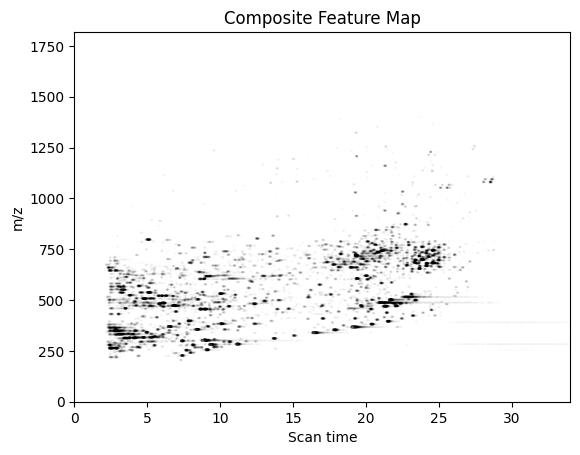

In [72]:
## A visualization of the raw data can be generated
# plots the scan time as the independent variable and the m/z value as the dependent value
# darkness of each point indicates the intensity detected at the m/z value
myLCMSobj.plot_composite_mz_features(mf_plot=False, ms2_plot=False)

## Set Parameters

To perform any data processing, we need to set parameters appropriately.  We'll walk through a few of the available parameters here.  For more complete documentation, see the [API documentation for encapsualted parameters](https://emsl-computing.github.io/CoreMS/corems/encapsulation/factory.html).

In [73]:
## Setting parameters appropriate for experimentation

## Set parameters on the LCMS object that are reasonable for testing (speed things up for this example)
# persistent homology parameters control the thresholds for peak picking, see corems/corems/encapsulation/factory/processSetting.py
# adjusted for demonstration purposes to improve runtime
# based on observation, smoothing does not improve peak picking for these type of data
myLCMSobj.parameters.lc_ms.ph_inten_min_rel = 0.05      # default is 0.001
myLCMSobj.parameters.lc_ms.ph_persis_min_rel = 0.05     # default is 0.001
myLCMSobj.parameters.lc_ms.ph_smooth_it = 0             # default is 1

## MSParameters for ms1 mass spectra
# see corems/corems/encapsulation/factory/parameters.py
## set parameters for how to process an individual mass spectrum object
ms1_params = myLCMSobj.parameters.mass_spectrum["ms1"]
ms1_params.mass_spectrum.noise_threshold_method = "relative_abundance"
ms1_params.mass_spectrum.noise_threshold_min_relative_abundance = 0.1
ms1_params.mass_spectrum.noise_min_mz, ms1_params.mass_spectrum.min_picking_mz = 0, 0
ms1_params.mass_spectrum.noise_max_mz, ms1_params.mass_spectrum.max_picking_mz = (
    np.inf,
    np.inf,
)
ms1_params.ms_peak.legacy_resolving_power = False

## set parameters for how to apply molecular formula searches to MS objects
ms1_params.molecular_search.url_database = (
    ""  ## this will default to using a local sqlite database
)
ms1_params.molecular_search.usedAtoms = {
    "C": (10, 30),  # default (1, 90)
    "H": (18, 200),  # default (4, 200)
    "O": (1, 23),  # default (0, 12)
    "N": (0, 3),  # default (0, 0)
    "P": (0, 1),  # default (0, 0)
    "S": (0, 1),  # default (0, 0)
}

## settings for MS2 data (HCD scans), same as ms1_params
# for these example data, we have HCD scans that are similar to MS1 scans in resolution, so we'll use the same parameters
# see corems/corems/encapsulation/factory/processSetting.py
ms2_params_hcd = ms1_params.copy()
myLCMSobj.parameters.mass_spectrum["ms2"] = ms2_params_hcd

## settings for ms2 data (CID scans), one change from ms1_params
# for these example data, we have CID scans that are lower resolution than MS1 scans, 
# so we'll use slightly different parameters for processing those spectra
# lower noise threshold for CID scans
ms2_params_cid = ms2_params_hcd.copy()
ms2_params_cid.mass_spectrum.noise_threshold_min_relative_abundance = 0.01
myLCMSobj.parameters.mass_spectrum["ms2_cid"] = ms2_params_cid

## Identify MS1 M/Z features

The first step for processing these data will be to identify m/z features (unique m/z x retention time pairs) in the data.  We'll use an approach based on persitent homology to do this. 

In [74]:
## Identify the MZ features from the raw data using the persistent homology method
# see corems/corems/mass_spectra/calc/lc_calc.py
myLCMSobj.find_mass_features()

## The previous function generated a summarizing dataframe to quickly reference the identified attributes
# Some columns are initiated but require additional function calls to be completed
myLCMSobj.mass_features_to_df()

Found 81 initial mass features
50 mass features remaining


,scan_time,mz,apex_scan,start_scan,final_scan,intensity,persistence,area,dispersity_index,monoisotopic_mf_id,isotopologue_type,mass_spectrum_deconvoluted_parent
mf_id,,,,,,,,,,,,
0,8.895637,301.216614,1882.0,None,None,66775328.0,63432449.0,None,None,None,None,None
1,19.152648,367.357483,4069.0,None,None,48137056.0,44794177.0,None,None,None,None,None
3,16.438137,339.326111,3484.0,None,None,35888348.0,32545469.0,None,None,None,None,None
4,8.378137,355.321167,1756.0,None,None,25525068.0,22182189.0,None,None,None,None,None
5,6.515803,369.300629,1297.0,None,None,25392018.0,22049139.0,None,None,None,None,None
6,9.397805,281.248322,2008.0,None,None,24492228.0,21149349.0,None,None,None,None,None
7,11.155970,283.264038,2422.0,None,None,23294938.0,19952059.0,None,None,None,None,None
8,21.274803,469.404755,4600.0,None,None,22771026.0,19428147.0,None,None,None,None,None
10,9.071805,255.233109,1927.0,None,None,20920262.0,17577383.0,None,None,None,None,None


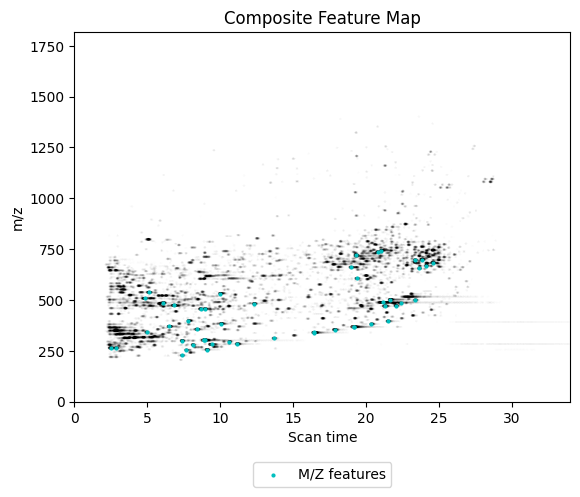

In [75]:
## After calling .find_mass_features, the raw data plot can now be recreated with M/Z features highlighted in blue
myLCMSobj.plot_composite_mz_features(ms2_plot=False)

In [76]:
## Calls exist to easily retrieve MZ feature specific data
# Call the first MZ feature (index 0)
# List of available properties found in corems/corems/chroma_peak/factory/chroma_peak_classes.py, LCMSMassFeature class
# 'Scan time' is used interchangably with 'Retention time'
myLCMSobj.mass_features[0].retention_time

8.895636666666666

In [77]:
myLCMSobj.mass_features[0].mz

301.21661376953125

In [78]:
myLCMSobj.mass_features[0].intensity

66775328.0

## Add the associated MS1 spectra

Next we'll add the MS1 spectra to the data object.  This will allow us to perform further processing specifically on the MS1 spectra using functionality in the `corems.mass_spectrum` module.

In [79]:
## Instantiate Mass Spectrum objects and store on LCMS object
# this will only add MS1 specttra to the object that are associated with the MZ features
# we will automatically process the MS1 spectra (`auto_process=True`) since we've set our parameters for processing
# we will not use the parser to process the data (`use_parser=False`) since we've already parsed the ms1 data from the raw file
# we will set the spectrum mode to 'profile' since these are profile data, and the process is much faster if we declare the spectrum mode
myLCMSobj.add_associated_ms1(
    auto_process=True, use_parser=False, spectrum_mode="profile"
)

50 mass features remaining


In [80]:
# This call does not add any new information to the .mass_features_to_df() result
# Instead, examine the properties of the identifed MS1 which can be called by their identification keys
print(myLCMSobj.ms.keys())

dict_keys([271, 370, 883, 910, 955, 1198, 1297, 1378, 1513, 1585, 1621, 1693, 1756, 1819, 1882, 1891, 1900, 1927, 2008, 2152, 2170, 2305, 2422, 2674, 2953, 3484, 3781, 4024, 4069, 4105, 4123, 4375, 4483, 4546, 4564, 4600, 4654, 4690, 4780, 4861, 5095, 5167, 5212, 5284, 5392])


In [81]:
# Mass Spectrum objects inhereit properties from MassSpecBase class, corems/corems/mass_spectrum/factory/MassSpectrumClasses.py
# Examine sample spectrum
key = list(myLCMSobj.ms.keys())[0]

## Sample attributes that are now stored on the myLCMS object
print("Abundances as array:")
print(myLCMSobj.ms[key].abundance)
print()
print("M/Z values as array:")
print(myLCMSobj.ms[key].mz_exp)
print()
print("Total ion current of mass spectrum:")
print(myLCMSobj.ms[key].tic)

Abundances as array:
[19102.68164062 16486.91992188 12420.82617188 ... 47565.3515625
 17303.453125   23495.61914062]

M/Z values as array:
[ 201.12873571  207.06647899  207.13928165 ... 1860.54140956 1924.33663261
 1958.86048751]

Total ion current of mass spectrum:
13535584.304467887


<Axes: xlabel='$\t{m/z}$', ylabel='Abundance'>

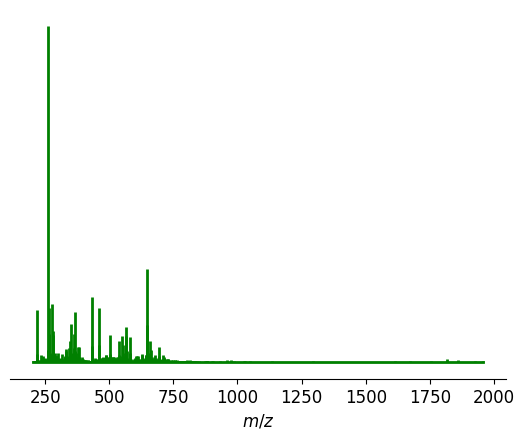

In [82]:
## Visualize the identified spectrum
myLCMSobj._ms[key].plot_centroid()

## Integrate M/Z Features

For the next step, we'll integrate the m/z features to get the intensity and area under the curve for each feature.  This will pull in extracted ion chromatograms (EICs) for each unique m/z value in the m/z features and integrate the area under the curve for each feature.

In [83]:
## Integrate mass features and extract EICs
# fills in the start_scan, final_scan, and area values for the M/Z features
# drop_if_fail argument discards M/Z features that fail to find a left and right limit on a peak
# see corems/corems/mass_spectra/calc/lc_calc.py
myLCMSobj.integrate_mass_features(drop_if_fail=True)

# export data with mass_features_to_df() to see updated table of M/Z features
myLCMSobj.mass_features_to_df()

,scan_time,mz,apex_scan,start_scan,final_scan,intensity,persistence,area,dispersity_index,monoisotopic_mf_id,isotopologue_type,mass_spectrum_deconvoluted_parent
mf_id,,,,,,,,,,,,
0,8.895637,301.216844,1882.0,1828,2008,66775328.0,63432449.0,3.504558e+07,None,None,None,None
1,19.152648,367.357482,4069.0,4024,4312,48137056.0,44794177.0,3.064127e+07,None,None,None,None
3,16.438137,339.326190,3484.0,3448,3673,35888348.0,32545469.0,2.245067e+07,None,None,None,None
4,8.378137,355.321396,1756.0,1729,1936,25525068.0,22182189.0,1.122322e+07,None,None,None,None
5,6.515803,369.300726,1297.0,1261,1378,25392018.0,22049139.0,1.176696e+07,None,None,None,None
6,9.397805,281.248274,2008.0,1954,2053,24492228.0,21149349.0,1.207856e+07,None,None,None,None
7,11.155970,283.263763,2422.0,2386,2683,23294938.0,19952059.0,1.250162e+07,None,None,None,None
8,21.274803,469.404560,4600.0,4564,4735,22771026.0,19428147.0,1.186232e+07,None,None,None,None
10,9.071805,255.232861,1927.0,1891,2008,20920262.0,17577383.0,7.909295e+06,None,None,None,None


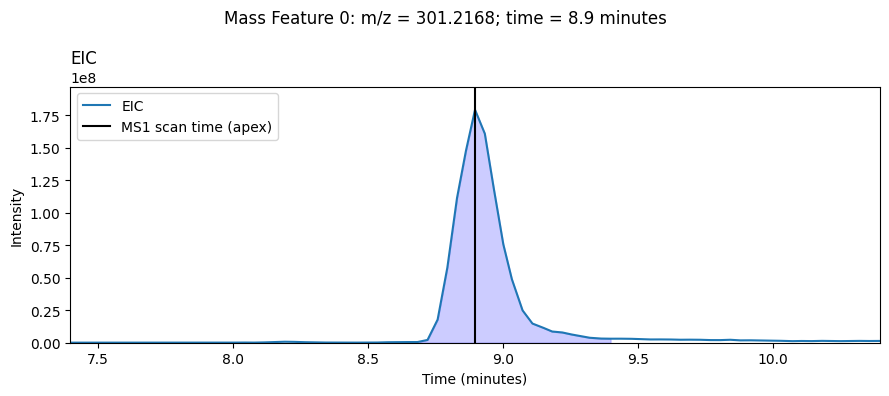

In [84]:
# Generate visualizations of M/Z features
# see more options at corems/chroma_peak/factory/chroma_peak_classes.py
myLCMSobj.mass_features[0].plot(to_plot=["EIC"])

## Deconvolute MS1 M/Z features

The MS1 spectra associated with each m/z feature can be deconvoluted across the retention time dimension to identify the m/z peaks within the ms1 spectra that are associated with the m/z feature.  This will help us to identify the m/z peaks that are associated with each m/z feature.

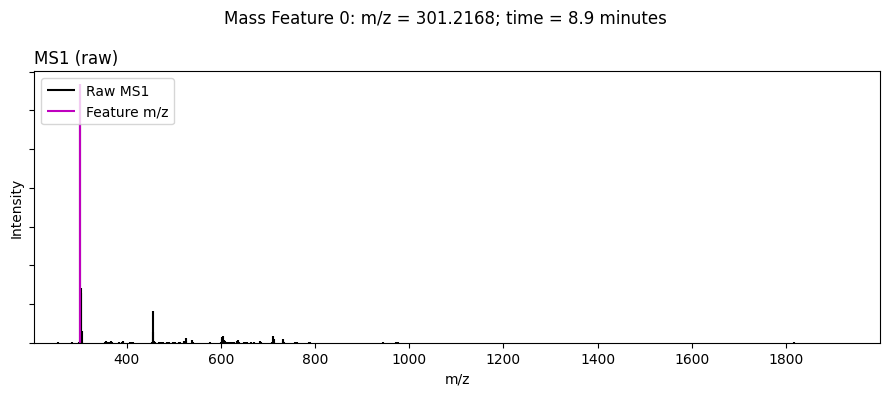

In [85]:
# Visualize raw MS1 M/Z feature
myLCMSobj.mass_features[0].plot(to_plot=["MS1"])

In [86]:
## Deconvolute the MS1 M/Z features
# Identifies each M/Z feature with boolean indicating if mass_spectrum_deconvoluted_parent exists
# see corems/corems/mass_spectra/calc/lc_calc.py
myLCMSobj.deconvolute_ms1_mass_features()

# export data with mass_features_to_df() to see updated table of M/Z features
myLCMSobj.mass_features_to_df()

,scan_time,mz,apex_scan,start_scan,final_scan,intensity,persistence,area,dispersity_index,monoisotopic_mf_id,isotopologue_type,mass_spectrum_deconvoluted_parent,associated_mass_features
mf_id,,,,,,,,,,,,,
0,8.895637,301.216844,1882.0,1828,2008,66775328.0,63432449.0,3.504558e+07,None,None,None,True,"0, 22, 35"
1,19.152648,367.357482,4069.0,4024,4312,48137056.0,44794177.0,3.064127e+07,None,None,None,True,"1, 48"
3,16.438137,339.326190,3484.0,3448,3673,35888348.0,32545469.0,2.245067e+07,None,None,None,True,"3, 67"
4,8.378137,355.321396,1756.0,1729,1936,25525068.0,22182189.0,1.122322e+07,None,None,None,True,4
5,6.515803,369.300726,1297.0,1261,1378,25392018.0,22049139.0,1.176696e+07,None,None,None,True,5
6,9.397805,281.248274,2008.0,1954,2053,24492228.0,21149349.0,1.207856e+07,None,None,None,True,6
7,11.155970,283.263763,2422.0,2386,2683,23294938.0,19952059.0,1.250162e+07,None,None,None,True,7
8,21.274803,469.404560,4600.0,4564,4735,22771026.0,19428147.0,1.186232e+07,None,None,None,True,8
10,9.071805,255.232861,1927.0,1891,2008,20920262.0,17577383.0,7.909295e+06,None,None,None,True,10


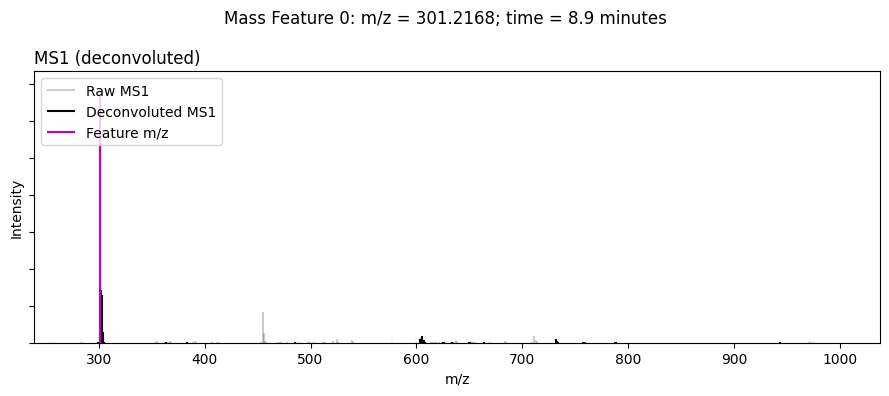

In [87]:
# Visualize deconvoluted MS1 M/Z feature
myLCMSobj.mass_features[0].plot(to_plot=["MS1"])

## Add additional peak shape 

This next step will add additional peak shape information to each of the m/z features on the data object.  These include half height width, tailing factor, and dispersity index.

In [88]:
## Add more peak metrics, see corems/corems/mass_spectra/calc/lc_calc.py
# fills in dispersity_index and adds columns half_height_width and tailing_factor when possible
myLCMSobj.add_peak_metrics()

# export data with mass_features_to_df() to see updated table of M/Z features
myLCMSobj.mass_features_to_df()

,scan_time,mz,apex_scan,start_scan,final_scan,intensity,persistence,area,half_height_width,tailing_factor,dispersity_index,monoisotopic_mf_id,isotopologue_type,mass_spectrum_deconvoluted_parent,associated_mass_features
mf_id,,,,,,,,,,,,,,,
0,8.895637,301.216844,1882.0,1828,2008,66775328.0,63432449.0,3.504558e+07,0.171916,1.468982,0.028584,None,None,True,"0, 22, 35"
1,19.152648,367.357482,4069.0,4024,4312,48137056.0,44794177.0,3.064127e+07,0.184506,1.739617,0.029239,None,None,True,"1, 48"
3,16.438137,339.326190,3484.0,3448,3673,35888348.0,32545469.0,2.245067e+07,0.185752,1.722910,0.026417,None,None,True,"3, 67"
4,8.378137,355.321396,1756.0,1729,1936,25525068.0,22182189.0,1.122322e+07,0.154333,1.664411,0.021417,None,None,True,4
5,6.515803,369.300726,1297.0,1261,1378,25392018.0,22049139.0,1.176696e+07,0.147667,1.299748,0.018750,None,None,True,5
6,9.397805,281.248274,2008.0,1954,2053,24492228.0,21149349.0,1.207856e+07,0.151494,NaN,0.017418,None,None,True,6
7,11.155970,283.263763,2422.0,2386,2683,23294938.0,19952059.0,1.250162e+07,0.160665,1.779602,0.021251,None,None,True,7
8,21.274803,469.404560,4600.0,4564,4735,22771026.0,19428147.0,1.186232e+07,0.181000,1.534575,0.017083,None,None,True,8
10,9.071805,255.232861,1927.0,1891,2008,20920262.0,17577383.0,7.909295e+06,0.149335,1.618215,0.018249,None,None,True,10


## Mark isotope peaks

We use the `find_c13_mass_features` method to identify likely 13C isotopic peaks in the data.

In [89]:
## Mark likely C13 isotopes and connect to M/Z features
# see corems/corems/mass_spectra/calc/lc_calc.py
myLCMSobj.find_c13_mass_features()

# export data with mass_features_to_df() to see updated table of M/Z features, note the monoisotopic_mf_id and isotopologue type columns are now filled where possible
myLCMSobj.mass_features_to_df()

evaluating mass features for C13 isotopes
0.12 of mass features have or are C13 isotopes


,scan_time,mz,apex_scan,start_scan,final_scan,intensity,persistence,area,half_height_width,tailing_factor,dispersity_index,monoisotopic_mf_id,isotopologue_type,mass_spectrum_deconvoluted_parent,associated_mass_features
mf_id,,,,,,,,,,,,,,,
0,8.895637,301.216844,1882.0,1828,2008,66775328.0,63432449.0,3.504558e+07,0.171916,1.468982,0.028584,0,None,True,"0, 22, 35"
1,19.152648,367.357482,4069.0,4024,4312,48137056.0,44794177.0,3.064127e+07,0.184506,1.739617,0.029239,1,None,True,"1, 48"
3,16.438137,339.326190,3484.0,3448,3673,35888348.0,32545469.0,2.245067e+07,0.185752,1.722910,0.026417,3,None,True,"3, 67"
4,8.378137,355.321396,1756.0,1729,1936,25525068.0,22182189.0,1.122322e+07,0.154333,1.664411,0.021417,None,None,True,4
5,6.515803,369.300726,1297.0,1261,1378,25392018.0,22049139.0,1.176696e+07,0.147667,1.299748,0.018750,None,None,True,5
6,9.397805,281.248274,2008.0,1954,2053,24492228.0,21149349.0,1.207856e+07,0.151494,NaN,0.017418,None,None,True,6
7,11.155970,283.263763,2422.0,2386,2683,23294938.0,19952059.0,1.250162e+07,0.160665,1.779602,0.021251,None,None,True,7
8,21.274803,469.404560,4600.0,4564,4735,22771026.0,19428147.0,1.186232e+07,0.181000,1.534575,0.017083,None,None,True,8
10,9.071805,255.232861,1927.0,1891,2008,20920262.0,17577383.0,7.909295e+06,0.149335,1.618215,0.018249,None,None,True,10


## Molecular formula search for m/z features

Next we'll perform a search for molecular formula associated with each m/z feature.  This will use the m/z value and the associated MS1 spectra to search for molecular formula that are likely to be associated with each m/z feature.

In [90]:
## Perform a molecular search on all of the M/Z features' ms1 peaks
# see corems/corems/molecular_id/search/molecularFormulaSearch.py
# SearchMolecularFormulasLC() is a class and run_mass_feature_search() peforms the search
mol_form_search = SearchMolecularFormulasLC(myLCMSobj)
mol_form_search.run_mass_feature_search()

'runworker'  6.63 ms


Loading molecular formula database: 85554it [00:02, 33809.62it/s]
Started molecular formula search for class {"N": 3, "S": 1, "P": 1, "O": 6}, (de)protonated : 100%|██████████| 300/300 [00:00<00:00, 700.19it/s] 
Loading molecular formula database: 20706it [00:00, 28502.01it/s]
Started molecular formula search for class {"N": 3, "S": 1, "P": 1, "O": 23}, (de)protonated : 100%|██████████| 68/68 [00:00<00:00, 823.07it/s]


In [91]:
# Examine one peak in one M/Z feature
myLCMSobj.mass_features[0].ms1_peak[0].string

'C20 H30 O2'

In [92]:
# Summarize the MS1 annotations for the M/Z features as a dataframe
# see corems/corems/mass_spectra/factory/lc_class.py
myLCMSobj.mass_features_ms1_annot_to_df()

,m/z,Calibrated m/z,Calculated m/z,Peak Height,Peak Area,Resolving Power,S/N,Ion Charge,m/z Error (ppm),m/z Error Score,...,O,13C,18O,17O,N,P,15N,S,33S,34S
mf_id,,,,,,,,,,,,,,,,,,,,,
0,301.216844,301.216844,301.217304,66775328.0,207870.960423,77398.095874,43.548118,-1,-1.527720,3.473653e-01,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,367.357482,367.357482,367.358154,48137056.0,257301.948288,70824.280454,36.591263,-1,-1.830273,3.495195e-01,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,339.326190,339.326190,339.326854,35888348.0,166884.343737,73369.506973,39.352196,-1,-1.957770,4.369662e-01,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,355.321396,355.321396,355.321769,25525068.0,119802.079339,71415.246462,55.400228,-1,-1.049444,3.225838e-01,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,369.300726,369.300726,369.301033,25392018.0,123970.862580,70282.834803,54.951292,-1,-0.832162,3.511299e-01,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,483.420324,483.420324,483.424126,6827325.0,56187.278356,60632.339803,48.008490,-1,-7.863900,2.254002e-01,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
77,483.420324,483.420324,483.416732,6827325.0,56187.278356,60632.339803,48.008490,-1,7.431386,4.179315e-04,...,4.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
80,499.415115,499.415115,499.410798,6736558.5,53006.566752,59990.770759,23.164262,-1,8.644095,9.814147e-07,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN


In [93]:
# Examine the MS1 annotations for just one M/Z feature
myLCMSobj.mass_features[0].mass_spectrum.to_dataframe()

# Note that the run_mass_feature_search() method only searches the m/z values associated with m/z features, not the entire MS1 spectra, 
# which is why the number of annotations is very low when looking at the entire MS1 spectra

,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Peak Area,Resolving Power,S/N,Ion Charge,m/z Error (ppm),...,Heteroatom Class,Ion Type,Adduct,Is Isotopologue,Mono Isotopic Index,Molecular Formula,C,H,O,13C
0,4,301.216844,301.216844,301.217304,6.677533e+07,207870.960423,77398.095874,43.548118,-1,-1.527720,...,O2,de-protonated,NaN,0.0,NaN,C20 H30 O2,20.0,30.0,2.0,NaN
1,6,302.220226,302.220226,302.220659,1.424971e+07,57966.262528,76017.305600,9.431001,-1,-1.432391,...,13C1 O2,de-protonated,NaN,1.0,4.0,C19 H30 O2 13C1,19.0,30.0,2.0,1.0
2,7,303.224701,303.224701,303.224013,1.177640e+06,7164.784534,79525.785861,0.761942,-1,2.269011,...,13C2 O2,de-protonated,NaN,1.0,4.0,C18 H30 O2 13C2,18.0,30.0,2.0,2.0
3,0,255.232873,255.232873,NaN,2.853830e+05,2968.766668,85285.125031,0.187330,-1,NaN,...,unassigned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,283.264145,283.264145,NaN,1.872186e+05,912.909305,82699.729803,0.121356,-1,NaN,...,unassigned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,101,943.612183,943.612183,NaN,9.089924e+04,6367.798710,43261.615972,0.060277,-1,NaN,...,unassigned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,102,971.174237,971.174237,NaN,1.644620e+05,4594.795336,43498.964610,0.106697,-1,NaN,...,unassigned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,103,973.171472,973.171472,NaN,1.506594e+05,12551.528590,43027.769262,0.099644,-1,NaN,...,unassigned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,104,975.167958,975.167958,NaN,1.007498e+05,14326.864161,44686.160344,0.065497,-1,NaN,...,unassigned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## MS2 data

Next we'll add MS2 data to the data object.

In [94]:
## Add MS2 spectra associated with mass features to the data set
# populates the ms2_scan_numbers attribute in the mass_features dictionary
# see corems/corems/mass_spectra/factory/lc_class.py

# Add HCD MS2 data using the ms2 mass spectrum parameters
# we'll set the spectrum mode to 'centroid' since these are centroid data, and the process is much faster if we declare the spectrum mode
# we'll set the scan filter to 'hcd' since we only want to add the hcd scans first
# by default, these will be added using the parser, will be automatically processed, and will be associated with the mass spectrum parameters we set in the "ms2" slot
myLCMSobj.add_associated_ms2_dda(spectrum_mode="centroid", scan_filter="hcd")

# Add CID MS2 data using the ms2_cid mass spectrum parameters
# we'll set the spectrum mode to 'centroid' since these are centroid data, and the process is much faster if we declare the spectrum mode
# we'll set the scan filter to 'cid' since we only want to add the cid scans first
# we'll associate the CID scans with the ms2_cid mass spectrum parameters
# by default, these will be added using the parser, will be automatically processed, 
myLCMSobj.add_associated_ms2_dda(
    spectrum_mode="centroid", ms_params_key="ms2_cid", scan_filter="cid"
)

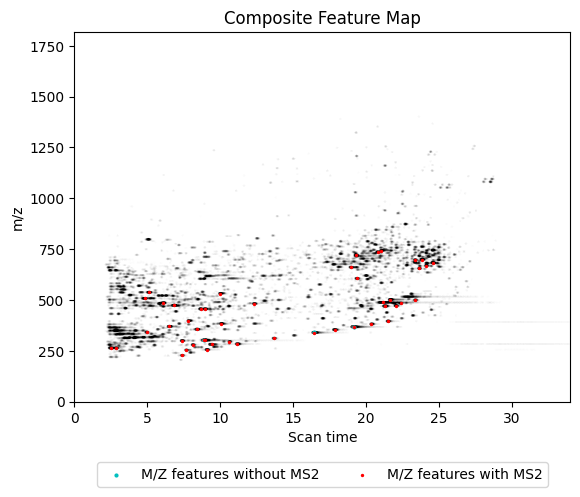

In [95]:
## The M/Z feature plot can now be generated with MS2 peaks identified (in red)
myLCMSobj.plot_composite_mz_features()

In [96]:
# MS2 spectra are now added to the main data frame (see column ms2_spectrum)
myLCMSobj.mass_features_to_df()

,scan_time,mz,apex_scan,start_scan,final_scan,intensity,persistence,area,half_height_width,tailing_factor,dispersity_index,monoisotopic_mf_id,isotopologue_type,mass_spectrum_deconvoluted_parent,associated_mass_features,ms2_spectrum
mf_id,,,,,,,,,,,,,,,,
0,8.895637,301.216844,1882.0,1828,2008,66775328.0,63432449.0,3.504558e+07,0.171916,1.468982,0.028584,0,None,True,"0, 22, 35",301.2174:1.0
1,19.152648,367.357482,4069.0,4024,4312,48137056.0,44794177.0,3.064127e+07,0.184506,1.739617,0.029239,1,None,True,"1, 48",367.3582:1.0
3,16.438137,339.326190,3484.0,3448,3673,35888348.0,32545469.0,2.245067e+07,0.185752,1.722910,0.026417,3,None,True,"3, 67",339.327:1.0
4,8.378137,355.321396,1756.0,1729,1936,25525068.0,22182189.0,1.122322e+07,0.154333,1.664411,0.021417,None,None,True,4,355.3217:1.0
5,6.515803,369.300726,1297.0,1261,1378,25392018.0,22049139.0,1.176696e+07,0.147667,1.299748,0.018750,None,None,True,5,369.3012:1.0
6,9.397805,281.248274,2008.0,1954,2053,24492228.0,21149349.0,1.207856e+07,0.151494,NaN,0.017418,None,None,True,6,281.2486:1.0
7,11.155970,283.263763,2422.0,2386,2683,23294938.0,19952059.0,1.250162e+07,0.160665,1.779602,0.021251,None,None,True,7,283.2642:1.0
8,21.274803,469.404560,4600.0,4564,4735,22771026.0,19428147.0,1.186232e+07,0.181000,1.534575,0.017083,None,None,True,8,469.4053:1.0; 470.4081:0.03
10,9.071805,255.232861,1927.0,1891,2008,20920262.0,17577383.0,7.909295e+06,0.149335,1.618215,0.018249,None,None,True,10,255.2332:1.0


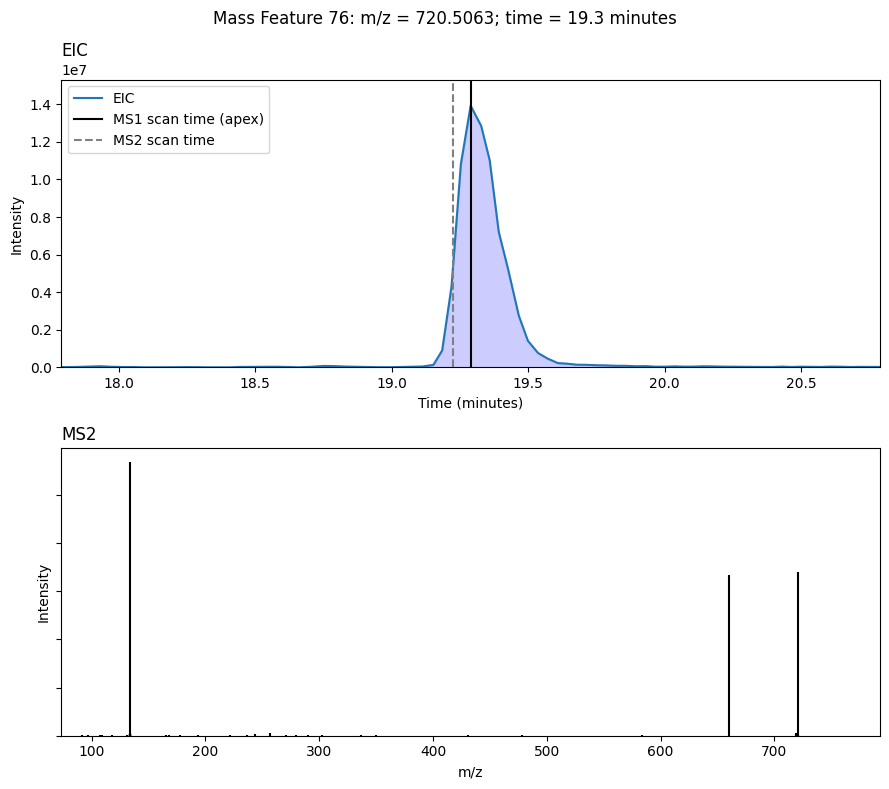

In [97]:
# Plot the MS2 spectrum associated with an M/Z feature (chosing a m/z feature with interesting ms2 data)
myLCMSobj.mass_features[76].plot(to_plot=["EIC", "MS2"])

## Export data

In [98]:
# Export the LCMS object using the LCMSExport class
# see corems/corems/mass_spectra/output/export.py
# contains more functions to clean and summarize data
exporter = LCMSExport(
    "Blanch_Nat_Lip_C_12_AB_M_17_NEG_25Jan18_Brandi-WCSH5801", myLCMSobj
)

# Save report as HDF5 file
exporter.to_hdf(overwrite=True)

## Clean up files

In [99]:
# Delete the "Blanch_Nat_Lip_C_12_AB_M_17_NEG_25Jan18_Brandi-WCSH5801.corems" directory
shutil.rmtree(
    "Blanch_Nat_Lip_C_12_AB_M_17_NEG_25Jan18_Brandi-WCSH5801.corems",
    ignore_errors=True,
)